In [1]:
import mitsuba as mi
import drjit as dr
import numpy as np
from sionna.rt import load_scene, Transmitter, Receiver, Camera

In [2]:
mi.set_variant("llvm_ad_mono_polarized")

In [3]:
import sionna.rt as rt

In [4]:
scene_path = r"C:\Users\sawyer\Documents\sionna_rt_jamming\data\downtown_chicago\DowntownChicago1KM.xml"
# concrete for floor/walls, metal for roofs
scene = load_scene(scene_path)

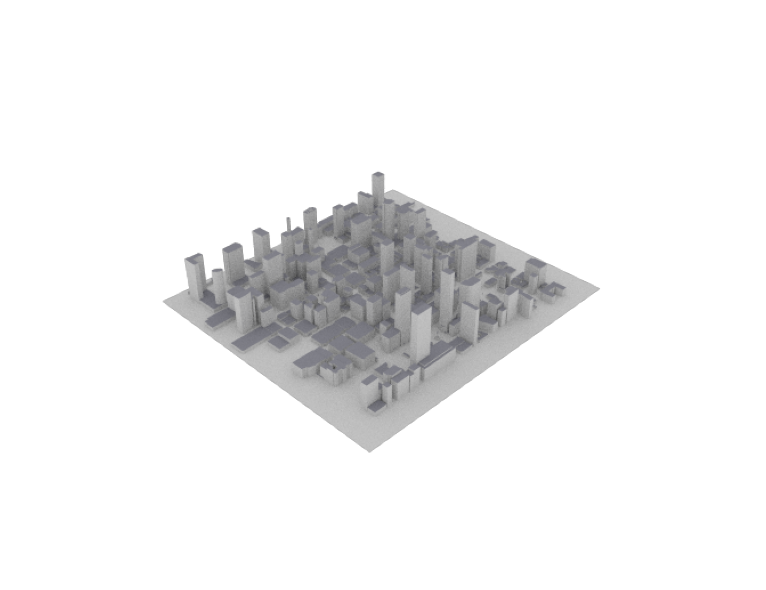

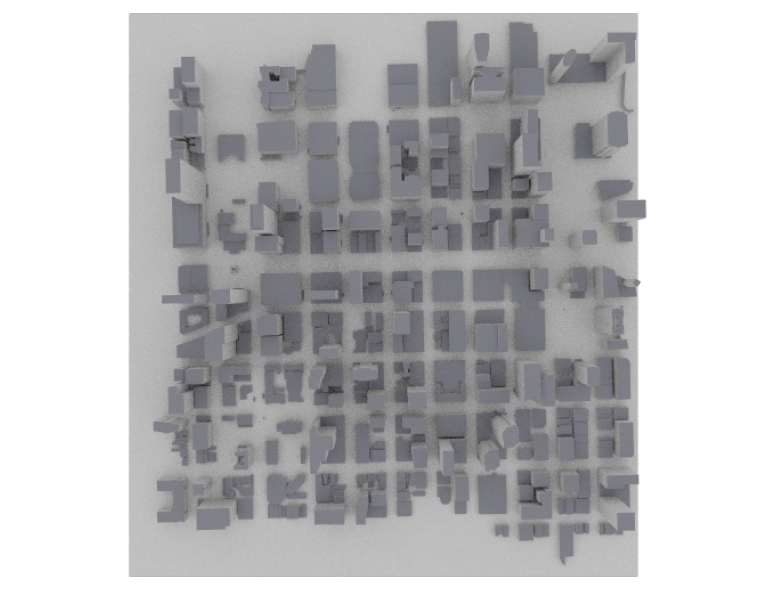

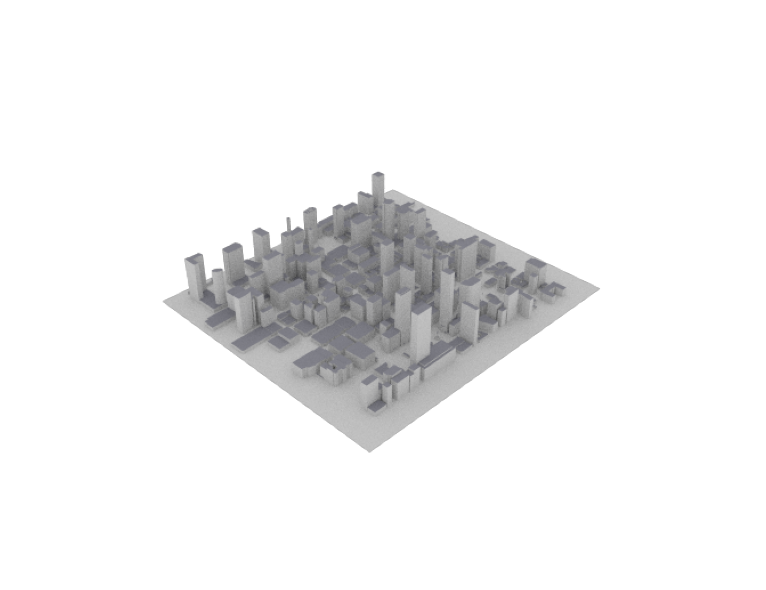

In [5]:
overhead = Camera(position=(0.0, 0.0, 2000.0))
overhead.look_at((0.0,0.0,0.0))
scene.render(camera=overhead)

isometric = Camera(position=(2000.0, 2000.0, 2000.0))
isometric.look_at((0.0,0.0,0.0))
scene.render(camera=isometric)

# Camera on render should be Z up, Y forwards!

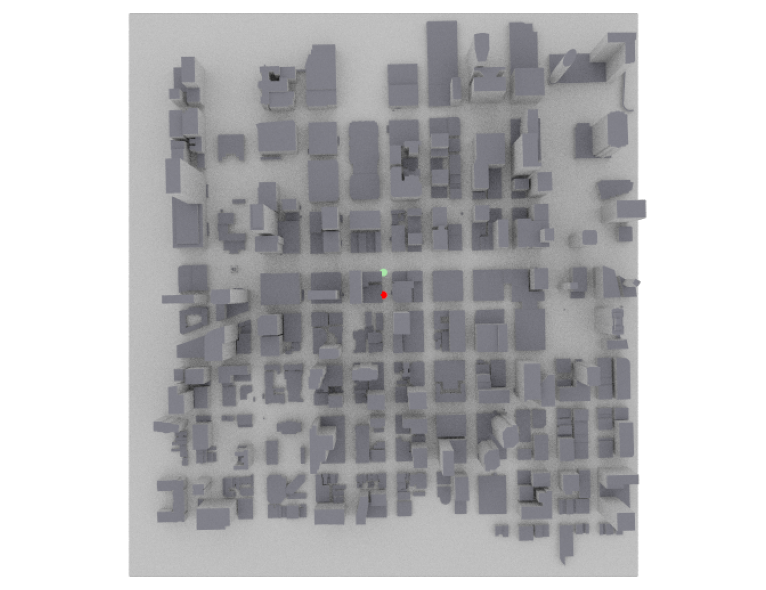

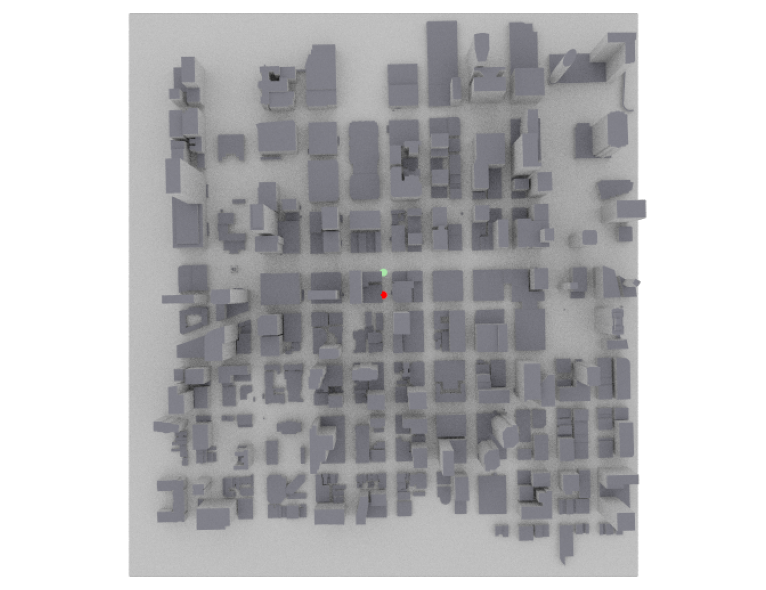

In [ ]:
# Set up antenna arrays
scene.tx_array = rt.PlanarArray(num_rows=1, num_cols=1, pattern="iso", polarization="V")
scene.rx_array = rt.PlanarArray(num_rows=1, num_cols=1, pattern="iso", polarization="V")

# Add Transmitter and Receiver
tx = Transmitter(name="Tx1", position=[0,0,10], color=[1.0, 0.0, 0.0])
rx = Receiver(name="Rx1", position=[50,20,10], color=[0.4, 0.8, 0.4])
scene.add(tx)
scene.add(rx)

# Visualize scene with transmitter and receiver in place
cam = Camera(position=(0.0, 0.0, 2000.0))
cam.look_at((0.0, 0.0, 0.0)) 
scene.render(camera=cam)


In [7]:
print("Computing propagation paths...")
path_solver = rt.PathSolver()
paths = path_solver(scene, max_depth=3)
print("Path computation done.")

# %%
# Get channel impulse response
a_list, tau_list = paths.cir()

# Convert to numpy arrays
a = np.array(a_list)
tau = np.array(tau_list)

print("Channel impulse response shape:", a.shape)
print("Delays (tau):", tau)

# %%
# Total received power (summing all paths and delays)
power_linear = np.sum(np.abs(a)**2)
power_db = 10 * np.log10(power_linear + 1e-12)

print(f"\n=== Signal Strength (Tx1 → Rx1) ===")
print(f"Power (linear): {power_linear:.6e}")
print(f"Power (dB): {power_db:.2f} dB")
print(f"\nChannel shape: {a.shape}")

Computing propagation paths...
Path computation done.
Channel impulse response shape: (2, 1, 1, 1, 1, 8, 1)
Delays (tau): [[[0.0000000e+00 1.6014781e-09 6.1359913e-08 5.6221523e-08 1.3939790e-06
   4.7774211e-07 7.0913870e-08 2.0668458e-06]]]

=== Signal Strength (Tx1 → Rx1) ===
Power (linear): 3.346437e-08
Power (dB): -74.75 dB

Channel shape: (2, 1, 1, 1, 1, 8, 1)


In [8]:
# Render Paths
scene.preview(paths=paths, resolution=[1200, 800], clip_at=15.)